In [1]:
import mne
import numpy as np
import pandas as pd

In [2]:
# Load the raw bdf file
raw = mne.io.read_raw_bdf('psyco dat/test_arpan_2_20cm.bdf')

# drop all channels except A16, A13, A32, A31, A7, A24
#raw.pick_channels(['A16', 'A13', 'A32', 'A31', 'A7', 'A24','A12','A19','Status','EXG7','EXG8'])
#raw.pick_channels(['A16', 'A13', 'A32', 'A31', 'A7', 'A24','A12','A19','Status'])
rename_map = {
    'A16': 'Oz',
    'A13': 'Pz',
    'A32': 'Cz',
    'A31': 'Fz',
    'A24': 'T8',
    'A7': 'T7',
    'A12': 'P3',
    'A19': 'P4',
}

# Rename channels
raw.rename_channels(rename_map)



Extracting EDF parameters from c:\Users\tomje\Documents\GitHub\Visual-Acuity-P3\psyco dat\test_arpan_2_20cm.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<RawEDF | test_arpan_2_20cm.bdf, 42 x 2695168 (1316.0 s), ~37 KiB, data not loaded>

In [3]:
min_duration = (2) / raw.info['sfreq']
events = mne.find_events(raw, min_duration=min_duration)

# print unique event IDs
unique_event_ids = np.unique(events[:, 2])
print("Unique event IDs:", unique_event_ids)

Trigger channel Status has a non-zero initial value of 130816 (consider using initial_event=True to detect this event)
4454 events found on stim channel Status
Event IDs: [65281 65282 65283 65284 65285 65286 65287 65288 65289 65290 65291 65292
 65293 65294 65295 65296 65297 65298 65299 65381 65383]
Unique event IDs: [65281 65282 65283 65284 65285 65286 65287 65288 65289 65290 65291 65292
 65293 65294 65295 65296 65297 65298 65299 65381 65383]


In [4]:
logical_triggers = [x & 0xFF for x in events[:, 2]]
logical_triggers = pd.Series(logical_triggers, name='Logical Triggers')
print(logical_triggers.value_counts())

Logical Triggers
9      427
7      423
2      420
6      417
4      411
1      407
5      397
3      387
8      382
103    262
101    259
19      34
18      30
16      30
14      28
10      27
13      26
17      26
12      24
15      20
11      17
Name: count, dtype: int64


In [5]:
# re reference the data to average of T7 and T8
raw.load_data()  # Load the data into memory
#raw.set_eeg_reference(ref_channels=['T7', 'T8'], projection=False)
raw.set_eeg_reference(ref_channels=['EXG7', 'EXG8'], projection=False)
# decimate the data to 256Hz
#raw.resample(256, npad='auto')
# filter above 30Hz lowpass
raw.filter(None, 30, fir_design='firwin', skip_by_annotation='edge')
# Save the modified raw data to a new file
#raw.save('/psyco dat/test_2-raw.fif', overwrite=True)

Reading 0 ... 2695167  =      0.000 ...  1316.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 903 samples (0.441 s)



<RawEDF | test_arpan_2_20cm.bdf, 42 x 2695168 (1316.0 s), ~863.7 MiB, data loaded>

Number of events with logical event ID 19: 32
Not setting metadata
32 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 32 events and 3483 original time points ...
0 bad epochs dropped
Need more than one channel to make topography for eeg. Disabling interactivity.


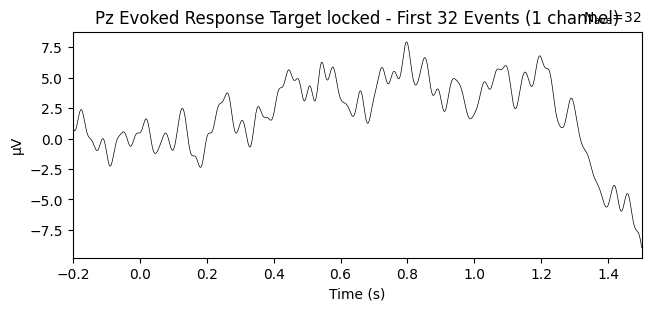

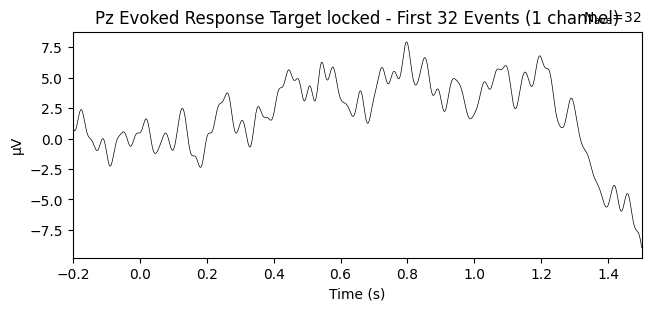

In [6]:
# Find indices of events with logical event ID 19
mask = [(x & 0xFF) > 9 and (x & 0xFF) < 100 for x in events[:, 2]]
#mask = (events[:, 2] & 0xFF) == 101
events_19 = events[mask]
# only take first 32 events
events_19 = events_19[:32]

reject = dict(eeg=100e-6)  # Reject epochs with peak-to-peak amplitude > 100 µV

print(f"Number of events with logical event ID 19: {len(events_19)}")

# Define epoch parameters
tmin = -0.2  # start 200ms before the trigger
tmax = 1.5 
epochs = mne.Epochs(raw, events_19, tmin=tmin, tmax=tmax, baseline=(-0.2, 0),reject=None, detrend=1, preload=True)



# Get evoked response for Pz
evoked = epochs.average().pick('Pz')


# Plot the evoked response
evoked.plot(titles='Pz Evoked Response Target locked - First 32 Events')

Using matplotlib as 2D backend.


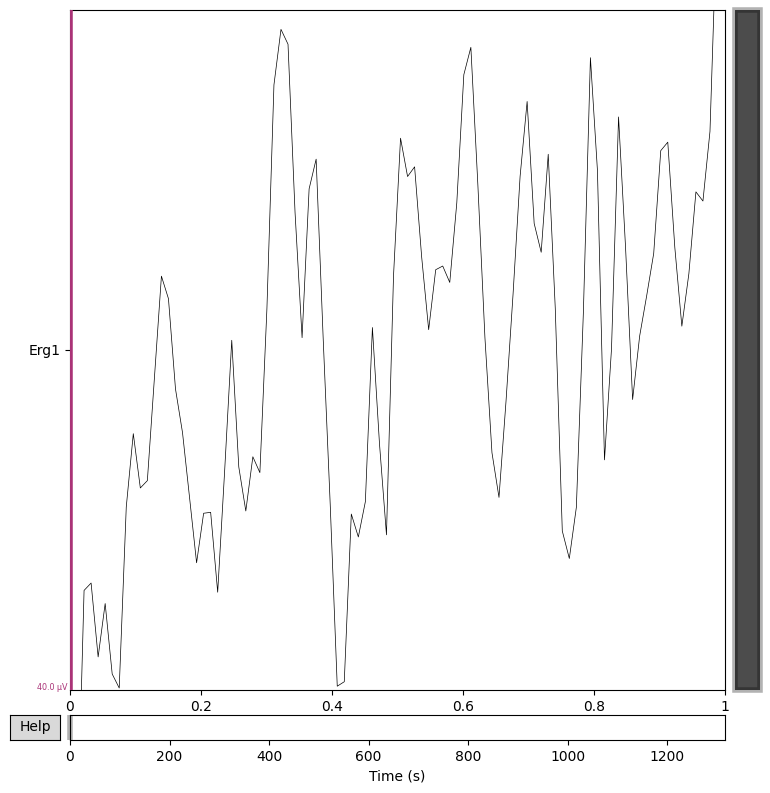

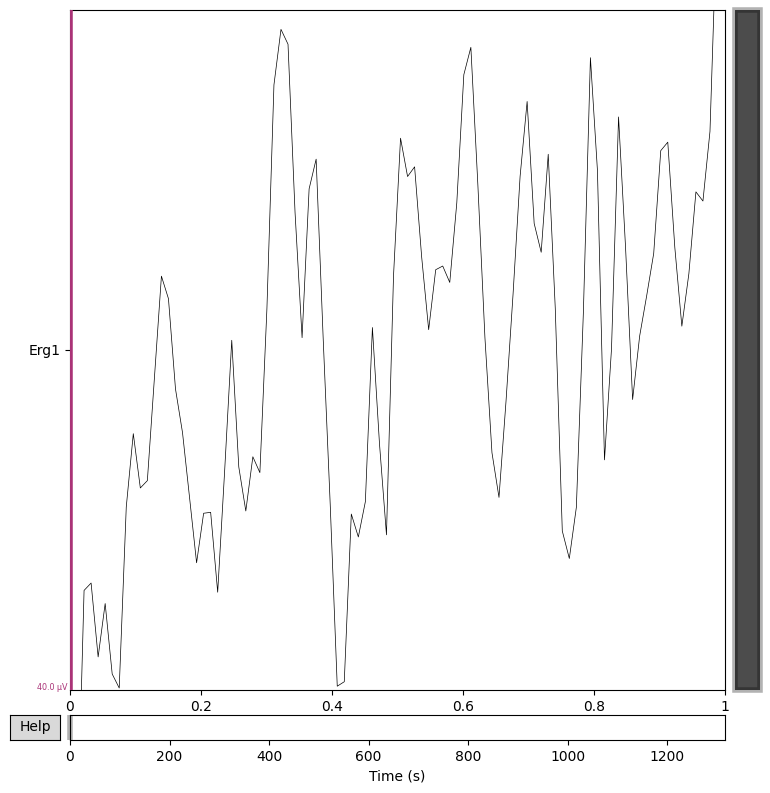

: 

In [ ]:
#plot stimulus channel
stim_channel = raw.copy().pick('Erg1')
stim_channel.plot(title='Stimulus Channel - Status', duration=1)

In [ ]:
photodiode_data, _ = raw.get_data(picks='Erg1', return_times=True)

# 2. Binarize the signal using a threshold.
# You need to determine a suitable threshold based on your data.
# Plotting the photodiode_data can help you choose a good value.
# threshold is 80th percentile of the signal
threshold = np.percentile(photodiode_data, 80)
binary_signal = (photodiode_data > threshold).astype(int)

# plot the binary signal
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(binary_signal, label='Binary Signal', color='orange')


 ...]